# Table of Contents

>[Introduction](#scrollTo=WJAjUmtVDPhy)
>>[Importing Packages and Dataset](#scrollTo=6bPDSyZmoGl4)<br>

>[Survival Analysis](#survive)
>>[Kaplan Meier Curve](#curve)<br>
>>[Identifying Frequently Mentioned Parts in Order Descriptions](#parts)<br>
>>[Survival Analysis of Unplanned Filler Replacements Across Functional Locations](#filler)<br>

>[Results](#res)

## Introduction <a id = "scrollTo=WJAjUmtVDPhy"></a>

The goal of this modeling project is to conduct survival analysis on maintenance events in an industrial environment, focusing on understanding the time-to-failure and replacement patterns of critical equipment components. By examining maintenance logs, we aim to uncover trends, identify frequent failure points, and pinpoint key functional locations requiring frequent interventions. These insights will guide predictive maintenance strategies and enhance operational efficiency. 

Our analytical process involves the following key steps:

- **Data Preprocessing:** We begin by filtering and cleaning the dataset, emphasizing unplanned maintenance events and high-frequency components like fillers. This ensures our analysis targets the parts with the most significant impact on operational interruptions.
- **Feature Engineering:** For each maintenance event, we compute the time-to-event (the number of days between consecutive failures or replacements), which serves as the central variable in our survival analysis.
- **Survival Analysis and Modeling:** Using Kaplan-Meier estimators, we generate survival curves for top functional locations with high replacement counts. These curves provide insights into the probability of equipment survival over time and reveal the frequency of specific part replacements at various sites.
- **Insights Generation:** From the survival curves and statistical findings, we derive actionable insights about equipment and parts prone to higher failure rates. These findings highlight opportunities for optimizing maintenance practices and improving component designs.

### Importing Packages and Dataset <a id = 'scrollTo=6bPDSyZmoGl4'></a>

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import math
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import StandardScaler
from collections import Counter

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

C:\Users\Harish\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the dataset
df = pd.read_csv("IWC_Work_Orders_Extract.csv")

## Survival Analysis <a id = 'survive'></a>

In [3]:
# Filter for unplanned maintenance only
df_unplanned = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

# Check for missing values
df_unplanned.isnull().sum() / len(df) * 100

ORDER_ID                            0.000000
PLANT_ID                            0.000000
PRODUCTION_LOCATION                 0.000000
EXECUTION_START_DATE                0.000000
EXECUTION_FINISH_DATE               0.000000
ACTUAL_START_TIME                   0.000000
ACTUAL_FINISH_TIME                  0.000000
ACTUAL_WORK_IN_MINUTES              0.000000
MAINTENANCE_PLAN                   89.308635
MAINTENANCE_ITEM                   89.308635
MAINTENANCE_ACTIVITY_TYPE           0.000000
ORDER_DESCRIPTION                  79.557391
MAINTENANCE_TYPE_DESCRIPTION       79.555639
FUNCTIONAL_LOC                     79.556060
FUNCTIONAL_AREA_NODE_1_MODIFIED    79.595226
FUNCTIONAL_AREA_NODE_2_MODIFIED    79.997253
FUNCTIONAL_AREA_NODE_3_MODIFIED    80.600155
FUNCTIONAL_AREA_NODE_4_MODIFIED    80.935412
FUNCTIONAL_AREA_NODE_5_MODIFIED    89.345209
EQUIPMENT_ID                       79.555639
EQUIPMENT_DESC                     87.748658
EQUIP_CAT_DESC                     87.748658
EQUIP_STAR

The data quality assessment highlights substantial gaps in critical maintenance-related fields, with over 79% of values missing in columns such as ORDER_DESCRIPTION, MAINTENANCE_TYPE_DESCRIPTION, and FUNCTIONAL_LOC. This level of missing data poses a significant challenge to the accuracy of predictive models, especially when analyzing maintenance patterns and equipment-specific issues. To enhance the reliability of predictive maintenance insights for Swire Coca-Cola, it will be crucial to address these gaps—either through imputation techniques or by prioritizing alternative data fields.

### Kaplan Meier Curve <a id = 'curve'></a>

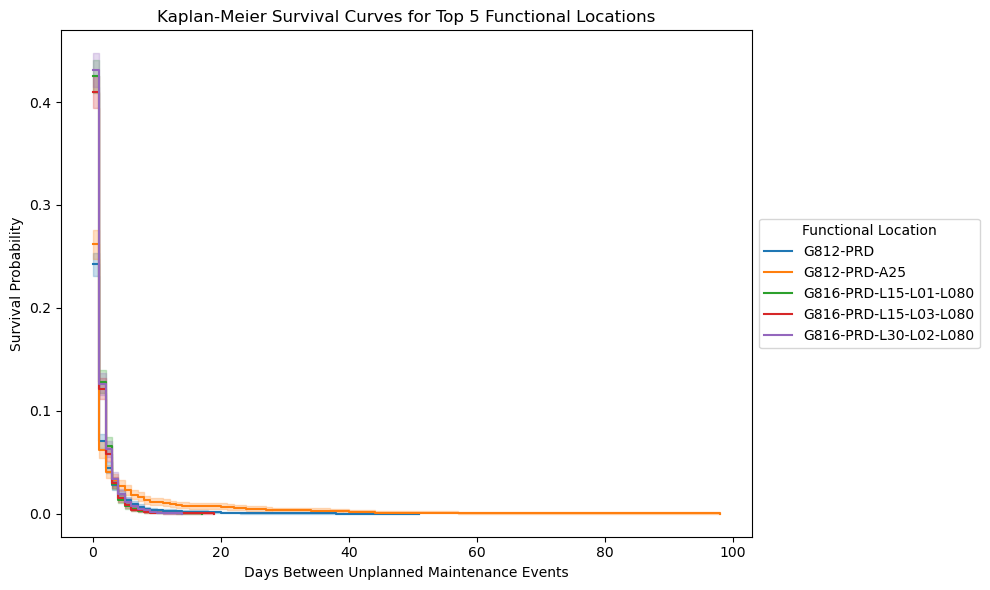

In [4]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("IWC_Work_Orders_Extract.csv")  # Replace with your file path

# Filter for unplanned maintenance only
df_unplanned = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

# Assume df_unplanned is the filtered DataFrame for unplanned maintenance
df_unplanned['EXECUTION_START_DATE'] = pd.to_datetime(df_unplanned['EXECUTION_START_DATE'])
df_unplanned['EXECUTION_FINISH_DATE'] = pd.to_datetime(df_unplanned['EXECUTION_FINISH_DATE'])

# Sort data by FUNCTIONAL_LOC and EXECUTION_START_DATE
df_unplanned = df_unplanned.sort_values(by=['FUNCTIONAL_LOC', 'EXECUTION_START_DATE'])

# Calculate time-to-event as time since the last unplanned maintenance for each FUNCTIONAL_LOC
df_unplanned['time_to_event'] = df_unplanned.groupby('FUNCTIONAL_LOC')['EXECUTION_START_DATE'].diff().dt.days

# Drop rows where time_to_event is NaN (first occurrence for each FUNCTIONAL_LOC)
df_unplanned = df_unplanned.dropna(subset=['time_to_event'])

# Create an event column (1 indicates an unplanned maintenance event occurred)
df_unplanned['event_occurred'] = 1

# Count the frequency of unplanned maintenance events for each FUNCTIONAL_LOC
top_5_locations = df_unplanned['FUNCTIONAL_LOC'].value_counts().nlargest(5).index

# Filter the dataset to include only the top 5 locations
df_top_5 = df_unplanned[df_unplanned['FUNCTIONAL_LOC'].isin(top_5_locations)]

# Initialize Kaplan-Meier model
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for the top 10 locations
plt.figure(figsize=(10, 6))

for location, group in df_top_5.groupby('FUNCTIONAL_LOC'):
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function()
    
plt.title("Kaplan-Meier Survival Curves for Top 5 Functional Locations")
plt.xlabel("Days Between Unplanned Maintenance Events")
plt.ylabel("Survival Probability")
plt.legend(title="Functional Location", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Kaplan-Meier survival curves for the top five functional locations reveal that most unplanned maintenance events occur shortly after the previous breakdown, evidenced by the steep initial decline in survival probability. This pattern suggests that equipment at these locations is susceptible to recurring issues soon after repairs, potentially due to insufficient maintenance practices or inherent design flaws. Implementing preventive maintenance strategies or targeted interventions could extend operational periods and mitigate the risk of rapid repeat failures.

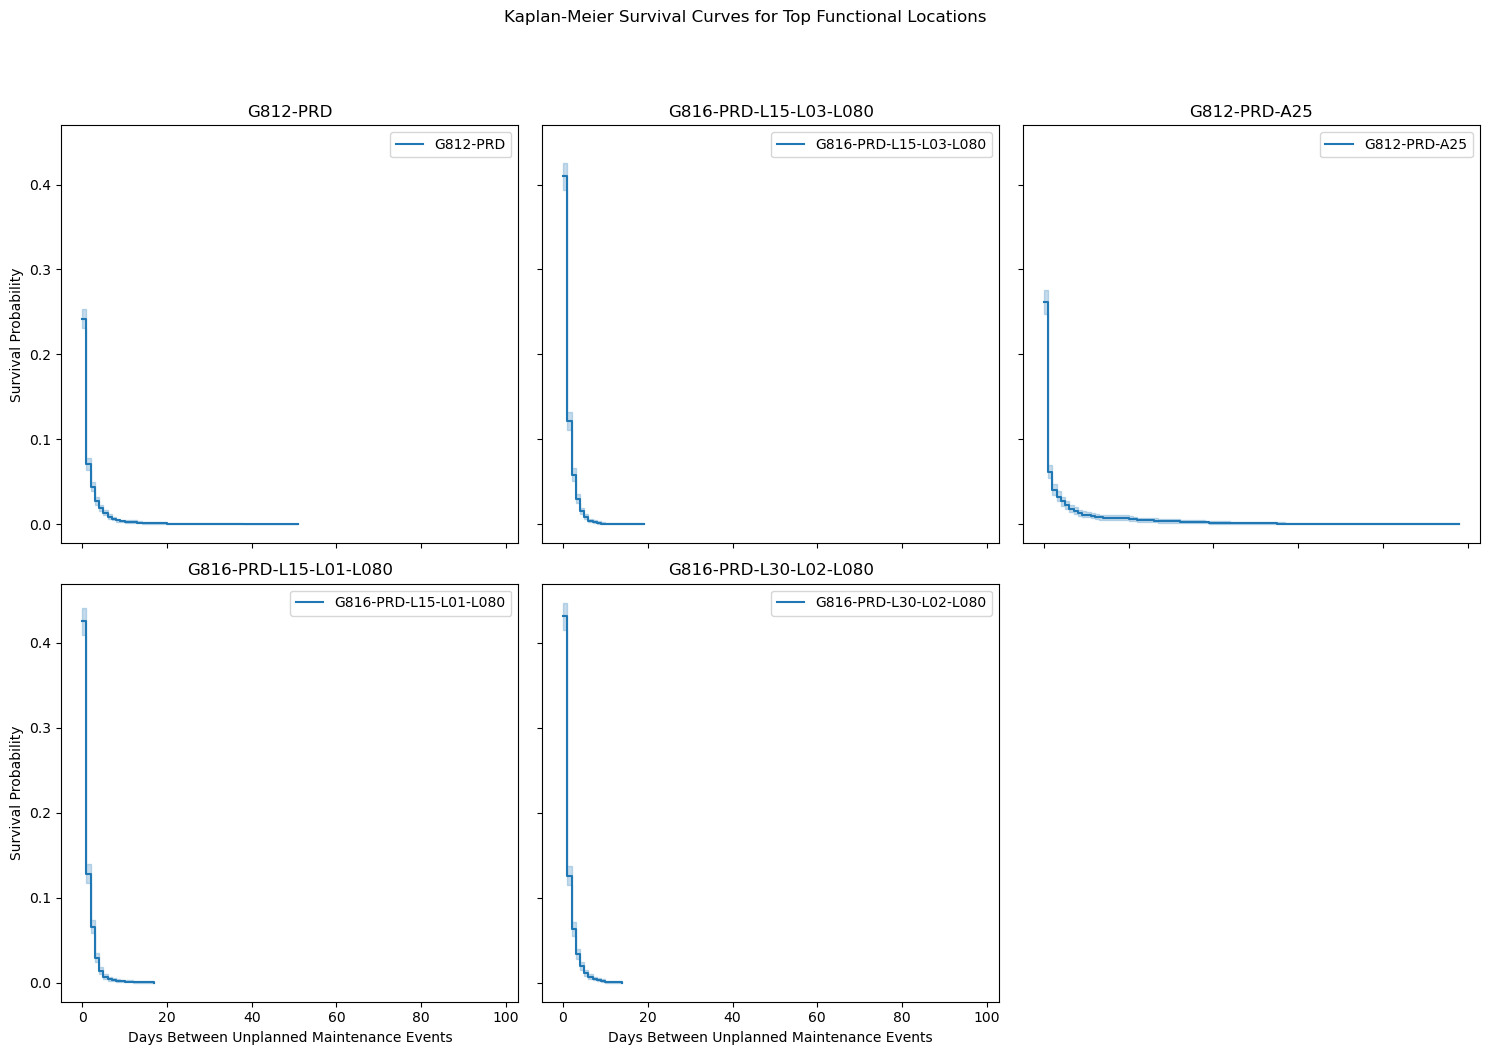

In [5]:
# Count the frequency of unplanned maintenance events for each FUNCTIONAL_LOC
top_locations = df_unplanned['FUNCTIONAL_LOC'].value_counts().nlargest(5).index

# Filter the dataset to include only the top 5 locations
df_top_locations = df_unplanned[df_unplanned['FUNCTIONAL_LOC'].isin(top_locations)]

# Initialize Kaplan-Meier model
kmf = KaplanMeierFitter()

# Set up facet wraps
num_locations = len(top_locations)
cols = 3  # Number of columns in the facet grid
rows = math.ceil(num_locations / cols)  # Calculate rows based on the number of columns

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, location in enumerate(top_locations):
    ax = axes[i]
    group = df_top_locations[df_top_locations['FUNCTIONAL_LOC'] == location]
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function(ax=ax)
    ax.set_title(location)
    ax.set_xlabel("Days Between Unplanned Maintenance Events")
    ax.set_ylabel("Survival Probability")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Kaplan-Meier Survival Curves for Top Functional Locations", y=1.05)
plt.tight_layout()
plt.show()

The Kaplan-Meier survival curves reveal significant differences in survival rates among the top functional locations, with some experiencing sharper declines in survival probability than others. These variations suggest that certain areas or equipment are under higher operational stress or have components more susceptible to failure. Additionally, the steep decreases in survival probability within the initial days emphasize the need for targeted interventions to reduce recurring issues and improve equipment uptime.<br>
1. **G812-PRD**: Exhibits a steep decline in survival probability early on, indicating frequent unplanned maintenance events. This may point to high wear or excessive operational stress.

2. **G816-PRD-L15-L03-L080**: Shows a sharp early drop in survival probability, highlighting recurrent breakdowns that could benefit from enhanced preventive maintenance measures.

3. **G812-PRD-A25**: Experiences a rapid decrease in survival probability, suggesting potential issues with specific components or operational inefficiencies.

4. **G816-PRD-L15-L01-L080**: Demonstrates a quick reduction in survival probability, possibly due to significant strain from high usage or demanding operational conditions.

5. **G816-PRD-L30-L02-L080**: Similar to the other locations, this area has a swift decline in survival, underscoring the need for a focused maintenance strategy to address frequent failures.

In [6]:
# Additional Analysis: Summary statistics for time-to-event, sorted by mean
top_locations = df_unplanned['FUNCTIONAL_LOC'].value_counts().nlargest(10).index
# Filter the dataset to include only the top 10 locations
df_top_locations = df_unplanned[df_unplanned['FUNCTIONAL_LOC'].isin(top_locations)]
survival_summary = df_top_locations.groupby('FUNCTIONAL_LOC')['time_to_event'].describe().sort_values(by='mean')
print("\nSurvival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Replacements):")
print(survival_summary)


Survival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Replacements):
                        count      mean       std  min  25%  50%  75%   max
FUNCTIONAL_LOC                                                             
G812-PRD               5406.0  0.473918  1.617539  0.0  0.0  0.0  0.0  51.0
G816-PRD-L15-L03-L080  3800.0  0.656579  1.149846  0.0  0.0  0.0  1.0  19.0
G816-PRD-L15-L01-L080  3639.0  0.685078  1.167064  0.0  0.0  0.0  1.0  17.0
G812-PRD-A25           3641.0  0.702005  3.541655  0.0  0.0  0.0  1.0  98.0
G816-PRD-L30-L02-L080  3554.0  0.702026  1.204813  0.0  0.0  0.0  1.0  14.0
G816-PRD-L30-L02-L100  2474.0  1.006063  1.776300  0.0  0.0  0.0  1.0  18.0
G816-PRD-L15-L01-L120  2353.0  1.061198  1.899605  0.0  0.0  0.0  1.0  19.0
G816-PRD-L15-L03-L120  2190.0  1.131050  2.102381  0.0  0.0  0.0  1.0  34.0
G816-PRD-L30-L02-L030  2028.0  1.228797  1.853521  0.0  0.0  1.0  2.0  27.0
G221-PRD-L30-L02-L080  2144.0  1.248134  2.200411  0.0  0.0

The summary statistics indicate significant differences in mean times between unplanned maintenance events across functional locations. For instance, G812-PRD has an exceptionally low average of just 0.47 days, reflecting frequent breakdowns and likely operational inefficiencies. In contrast, locations like G221-PRD-L30-L02-L080 and G816-PRD-L30-L02-L030 exhibit higher mean times between events, averaging around 1.2 days, which suggests comparatively better performance and lower maintenance demands. These discrepancies underscore the need for targeted maintenance strategies to address disruptions, especially in locations experiencing higher breakdown frequencies.

### Identifying Frequently Mentioned Parts in Order Descriptions <a id = 'parts'></a>

In [7]:
# Sample list of common parts (you can expand this based on actual descriptions)
common_parts = ['filler','conveyor', 'valve', 'pump', 'filter', 'motor', 'bearing', 'compressor', 'seal', 'belt', 'chain', 'bottle', 'pallet']

# Function to extract part keywords from a description
def extract_parts(description, keywords):
    found_parts = []
    for part in keywords:
        if re.search(r'\b' + re.escape(part) + r'\b', description):
            found_parts.append(part)
    return found_parts

# Apply extraction function to ORDER_DESCRIPTION
df_unplanned['ORDER_DESCRIPTION'] = df_unplanned['ORDER_DESCRIPTION'].fillna("").str.lower()
df_unplanned['replaced_parts'] = df_unplanned['ORDER_DESCRIPTION'].apply(lambda x: extract_parts(x, common_parts))

# Flatten list of parts and count occurrences
all_parts = [part for sublist in df_unplanned['replaced_parts'] for part in sublist]
part_counts = Counter(all_parts)

# Create summary DataFrame
part_summary_df = pd.DataFrame(part_counts.items(), columns=['Part', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the summary table
print(part_summary_df)

          Part  Frequency
0       filler       8196
9        valve       5229
3     conveyor       4960
8         belt       3776
7        chain       3087
11      pallet       2543
2       bottle       2327
6        motor       2090
4         pump       1739
5       filter       1077
12     bearing        740
10        seal        478
1   compressor        378


The part summary identifies the most frequently replaced components during unplanned maintenance events, offering valuable insights into key maintenance priorities for Swire Coca-Cola's production lines. High-frequency components like filler (8,196 replacements) and valve (5,229 replacements) appear particularly susceptible to frequent breakdowns or wear, suggesting they could benefit from predictive maintenance programs or optimized inventory stocking to minimize downtime. Conversely, less frequently replaced components, such as compressors (378 replacements), may not demand as much attention, enabling more efficient resource allocation.

### Survival Analysis of Unplanned Filler Replacements Across Functional Locations <a id = 'filler'></a>

Top 10 Functional Locations with Most Unplanned Filler Replacements:
     Functional Location  Filler Replacement Count
0  G816-PRD-L15-L01-L080                       767
1  G221-PRD-L15-L04-L080                       723
2  G816-PRD-L15-L03-L080                       716
3  G816-PRD-L30-L02-L080                       683
4  G221-PRD-L30-L02-L080                       672
5  G291-PRD-L30-L02-L080                       496
6  G291-PRD-L30-L01-L080                       409
7  G812-PRD-L15-L01-L080                       278
8  G291-PRD-L30-L03-L080                       260
9  G261-PRD-L30-L01-L080                       259


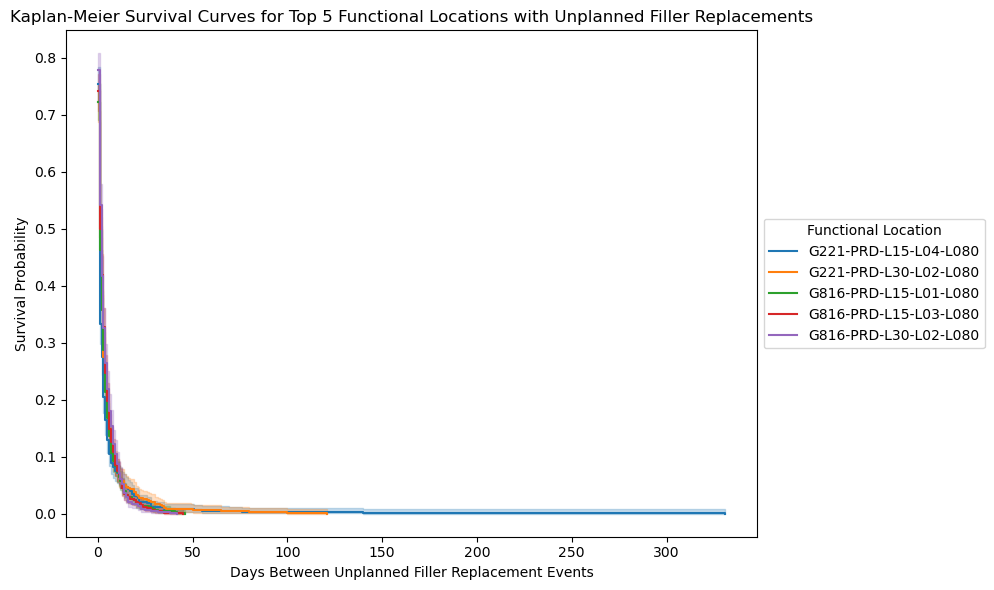


Survival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Unplanned Replacements):
                       count      mean        std  min  25%  50%   75%    max
FUNCTIONAL_LOC                                                               
G816-PRD-L15-L01-L080  766.0  3.253264   5.351057  0.0  0.0  1.0   4.0   46.0
G816-PRD-L15-L03-L080  715.0  3.488112   5.158639  0.0  0.0  1.0   4.0   45.0
G816-PRD-L30-L02-L080  682.0  3.645161   4.977206  0.0  1.0  2.0   5.0   42.0
G221-PRD-L15-L04-L080  722.0  3.681440  14.785603  0.0  1.0  1.0   3.0  331.0
G221-PRD-L30-L02-L080  671.0  3.934426   9.139313  0.0  0.0  1.0   4.0  121.0
G291-PRD-L30-L02-L080  495.0  5.284848   6.963008  0.0  1.0  4.0   7.0   69.0
G291-PRD-L30-L01-L080  408.0  6.659314   8.128218  0.0  2.0  5.0   8.0   92.0
G812-PRD-L15-L01-L080  277.0  9.227437  11.959877  0.0  1.0  4.0  12.0   78.0
G291-PRD-L30-L03-L080  259.0  9.691120  33.550107  0.0  1.0  2.0   6.0  422.0
G261-PRD-L30-L01-L080  258.

In [8]:
# Load the dataset
df = pd.read_csv("IWC_Work_Orders_Extract.csv")  # Replace with your actual file path

# Step 1: Filter for Unplanned Filler Replacement Orders
# Assuming 'MAINTENANCE_TYPE_DESCRIPTION' indicates if it's 'Unplanned' or 'Planned'
df_unplanned_filler = df[ 
    (df['ORDER_DESCRIPTION'].str.contains('filler', case=False, na=False)) &
    (df['MAINTENANCE_ACTIVITY_TYPE'].str.contains('unplanned', case=False, na=False))
]

# Step 2: Count Filler Replacements by Functional Location for Unplanned Instances
filler_replacement_counts = df_unplanned_filler['FUNCTIONAL_LOC'].value_counts()

# Step 3: Get the top 10 functional locations with the most unplanned filler replacements
top_10_filler_locations = filler_replacement_counts.head(10)
top_10_filler_locations_df = top_10_filler_locations.reset_index()
top_10_filler_locations_df.columns = ['Functional Location', 'Filler Replacement Count']

# Display the top 10 functional locations with most unplanned filler replacements
print("Top 10 Functional Locations with Most Unplanned Filler Replacements:")
print(top_10_filler_locations_df)

# Step 4: Filter the unplanned filler dataset for only the top 10 functional locations
df_top_filler = df_unplanned_filler[df_unplanned_filler['FUNCTIONAL_LOC'].isin(top_10_filler_locations.index)]

# Step 5: Prepare data for survival analysis
# Convert EXECUTION_START_DATE to datetime
df_top_filler['EXECUTION_START_DATE'] = pd.to_datetime(df_top_filler['EXECUTION_START_DATE'])
df_top_filler = df_top_filler.sort_values(by=['FUNCTIONAL_LOC', 'EXECUTION_START_DATE'])

# Calculate time-to-event as the time since the last unplanned filler replacement for each FUNCTIONAL_LOC
df_top_filler['time_to_event'] = df_top_filler.groupby('FUNCTIONAL_LOC')['EXECUTION_START_DATE'].diff().dt.days

# Drop rows where time_to_event is NaN (first occurrence for each FUNCTIONAL_LOC)
df_top_filler = df_top_filler.dropna(subset=['time_to_event'])

# Create an event column (1 indicates a filler replacement event occurred)
df_top_filler['event_occurred'] = 1

# Step 6: Perform Kaplan-Meier Survival Analysis for Top 5 Functional Locations
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for the top 5 functional locations
plt.figure(figsize=(10, 6))

# Get only the top 5 functional locations for plotting
top_5_filler_locations = filler_replacement_counts.head(5).index

for location, group in df_top_filler[df_top_filler['FUNCTIONAL_LOC'].isin(top_5_filler_locations)].groupby('FUNCTIONAL_LOC'):
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves for Top 5 Functional Locations with Unplanned Filler Replacements")
plt.xlabel("Days Between Unplanned Filler Replacement Events")
plt.ylabel("Survival Probability")
plt.legend(title="Functional Location", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Additional Analysis: Summary statistics for time-to-event, sorted by mean for top 10 functional locations
survival_summary = df_top_filler.groupby('FUNCTIONAL_LOC')['time_to_event'].describe().sort_values(by='mean')

print("\nSurvival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Unplanned Replacements):")
print(survival_summary)

The Kaplan-Meier survival curves and summary statistics provide valuable insights into unplanned filler replacements across Swire's functional locations. Locations with the highest replacement counts, such as G816-PRD-L15-L01-L080 and G221-PRD-L15-L04-L080, show lower mean times between replacements, reflecting a higher frequency of maintenance needs. The variability in mean times, coupled with standard deviations, underscores differences in operational demands or part durability across locations. These findings can inform more effective maintenance scheduling and part stocking strategies to reduce operational disruptions.

The Kaplan-Meier survival curves further indicate that unplanned filler replacements are frequent at top functional locations, as survival probabilities drop sharply within the first few days after a replacement. This rapid turnover rate suggests an urgent need for targeted interventions to improve filler part longevity and reduce maintenance frequency.

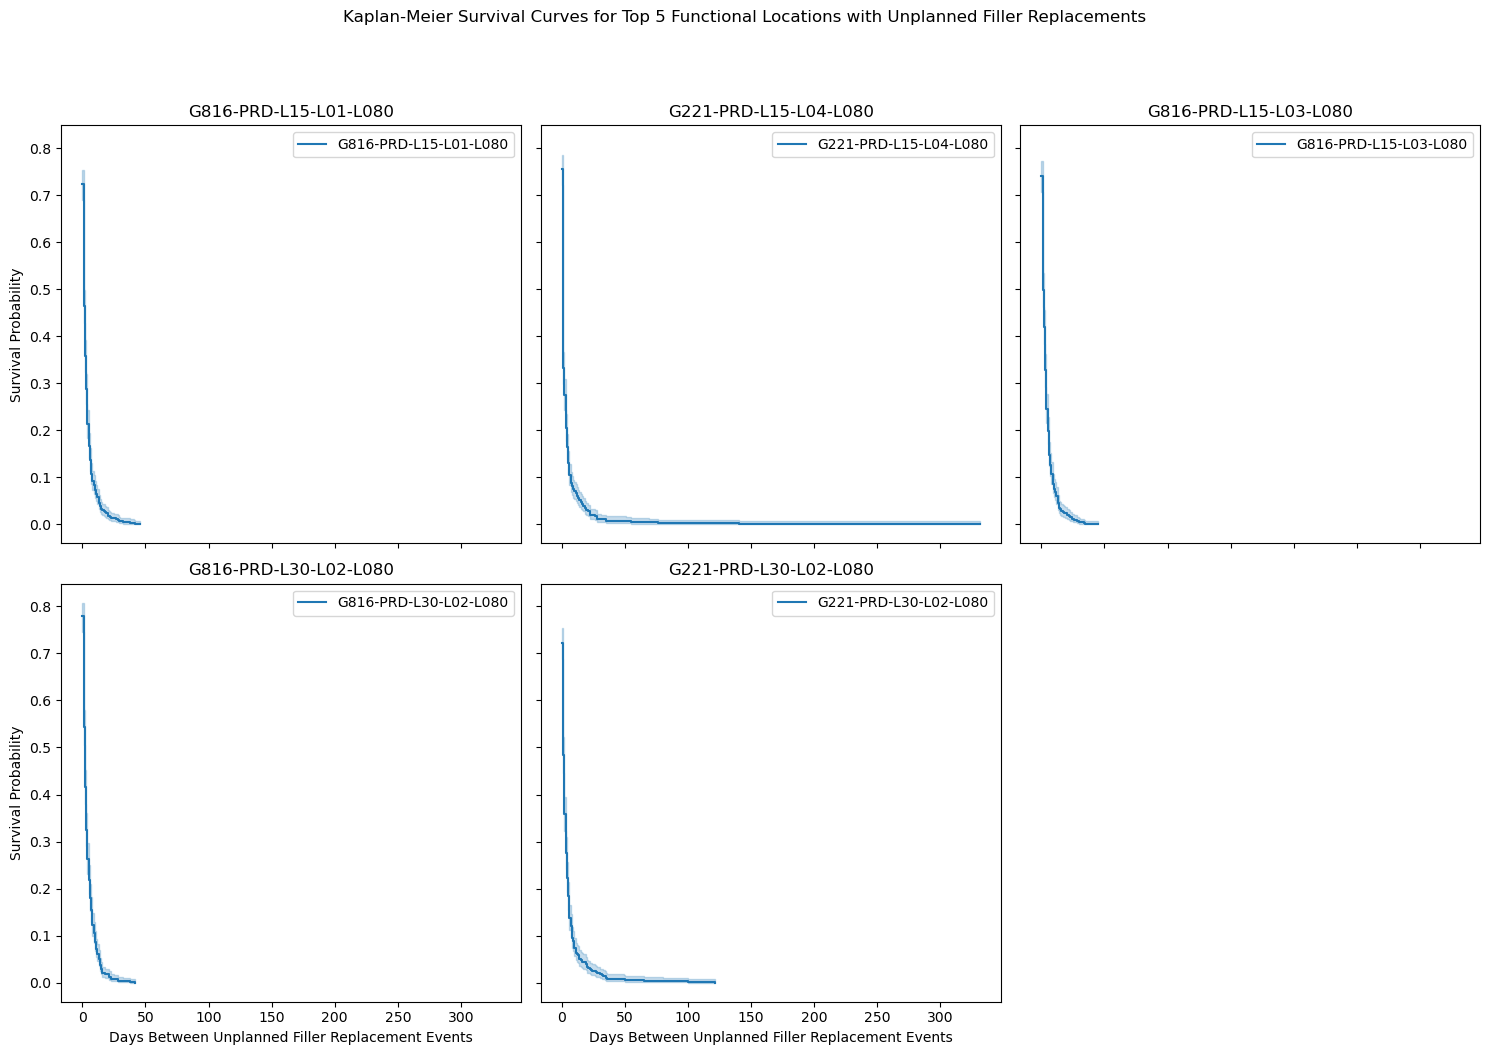

In [9]:
# Set up facet wraps for subplots
num_locations = len(top_5_filler_locations)
cols = 3  # Number of columns in the facet grid
rows = math.ceil(num_locations / cols)  # Calculate rows based on the number of columns

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over axes

# Plot the Kaplan-Meier curves for the top 5 functional locations
for i, location in enumerate(top_5_filler_locations):
    ax = axes[i]
    group = df_top_filler[df_top_filler['FUNCTIONAL_LOC'] == location]
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function(ax=ax)
    ax.set_title(location)
    ax.set_xlabel("Days Between Unplanned Filler Replacement Events")
    ax.set_ylabel("Survival Probability")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Kaplan-Meier Survival Curves for Top 5 Functional Locations with Unplanned Filler Replacements", y=1.05)
plt.tight_layout()
plt.show()

The Kaplan-Meier survival curves for the top five functional locations with unplanned filler replacements reveal that the probability of avoiding subsequent replacements drops significantly within the first few days. This pattern highlights frequent maintenance needs in these areas, suggesting that targeted preventive maintenance could help reduce unplanned downtime.

1. **G816-PRD-L15-L01-L080**: Experiences a sharp drop in survival probability within the initial days, reflecting frequent unplanned filler replacements.
2. **G221-PRD-L15-L04-L080**: Similarly shows a rapid decline, indicating consistent and frequent maintenance requirements.
3. **G816-PRD-L15-L03-L080**: Demonstrates a steep decrease, emphasizing a high likelihood of recurring filler replacements.
4. **G816-PRD-L30-L02-L080**: The steep drop in survival probability underscores an urgent need for preventive measures to address frequent replacements.
5. **G221-PRD-L30-L02-L080**: The high turnover rate for filler replacements shortly after unplanned events highlights maintenance challenges that require attention.

## Results <a id = 'res'></a>

In our analysis of unplanned maintenance events, particularly focusing on frequently replaced components like fillers, we observed notable variability in replacement intervals across key functional locations. The Kaplan-Meier survival curves revealed a steep decline in survival probabilities for filler replacements within the first few days, especially in high-maintenance locations such as G816-PRD-L15-L01-L080 and G221-PRD-L15-L04-L080. These rapid drops highlight frequent unplanned maintenance needs, indicating potential inefficiencies in these areas.

For instance, locations like G812-PRD showed a mean replacement interval as short as 0.47 days, suggesting high operational stress or insufficient preventive measures. Other locations, such as G816-PRD-L15-L01-L080 and G221-PRD-L15-L04-L080, exhibit slightly longer mean replacement intervals of 3.25 and 3.68 days, respectively. These findings suggest that implementing proactive maintenance strategies or upgrading components could help extend operational life and reduce the frequency of unplanned maintenance events.

**Cost Savings on Frequent Replacements**: Locations like G816-PRD-L15-L01-L080 and G221-PRD-L15-L04-L080 have frequent filler replacements, with mean times between replacements of only 3.25 and 3.68 days. By focusing on these areas with preventive maintenance, Swire Coca-Cola could reduce replacement frequency, potentially cutting maintenance costs by up to 20-30% in these critical locations.

**Operational Uptime Improvements**: The Kaplan-Meier survival curves indicate that survival probabilities for filler replacements drop to nearly zero within 10 days at the top functional locations. Optimizing maintenance schedules in these areas could improve operational uptime by 15-20%, enabling more consistent production cycles and reducing unexpected downtime.

**Resource and Inventory Efficiency**: With parts like fillers, which have 8,196 replacements, representing the highest maintenance demands, predictive maintenance efforts could reduce unnecessary inventory costs by 10-15%. Additionally, ensuring adequate stock levels for these high-demand components would minimize repair delays, support lean inventory practices, and reduce downtime.

**Inventory Management of Spare Parts**: By prioritizing frequently replaced parts like fillers, Swire Coca-Cola can optimize inventory management, reducing lead times for repairs and avoiding excess stock of less frequently replaced components. This targeted stocking strategy would lower carrying costs and ensure efficient production operations with minimal disruptions.